#### Plot the results of all regression experiments (Figure 5-6)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import csv
import os
import glob
import re

Helper function to aggregate coverage, average set sizes, and times

In [3]:
def pivot_csv(input_pattern='*.csv'):
    csv_files = glob.glob(input_pattern)
    
    size_data = {'Size': [], 'Alpha': [], 'Model': [], 'DataName': []}
    cover_data = {'Cover': [], 'Alpha': [], 'Model': [], 'DataName': []}
    time_data = {'Train': [], 'Test': [], 'Alpha': [], 'Model': [], 'DataName': [], 'Package': []}

    model_name = {"bootstrap":"J+-a-b", "cv": "CV+", "split":"Split"}
    
    for file in csv_files:
        filename = os.path.basename(file)
        parts = filename.split('_')

        assert len(parts) == 3 or len(parts) == 4
        data_name = parts[0]
        model = parts[1]
        if len(parts) == 4:
            k = parts[2]
            alpha = float(parts[3].replace('.csv', ''))
            package = None
        else:
            package = parts[2].replace('.csv', '')
            k = 0
            alpha = 0.05
        
        if k == 'auto':
            model = f"{model_name[model]} reg"
        else:
            model = model_name[model]
        
        try:
            df = pd.read_csv(file)
            
            size_value = df.iloc[0].to_list()
            cover_value = df.iloc[1].to_list()
            train_time_value = df.iloc[2].to_list()
            test_time_value = df.iloc[3].to_list()

            alpha_repeat = [alpha] * len(size_value)
            model_repeat = [model] * len(size_value)
            data_name_repeat = [data_name] * len(size_value)
            package_repeat = [package] * len(size_value)
            
            size_data['Size'] += size_value
            size_data['Alpha'] += alpha_repeat
            size_data['Model'] += model_repeat
            size_data['DataName'] += data_name_repeat
            
            cover_data['Cover'] += cover_value
            cover_data['Alpha'] += alpha_repeat
            cover_data['Model'] += model_repeat
            cover_data['DataName'] += data_name_repeat
            
            time_data['Train'] += train_time_value
            time_data['Test'] += test_time_value
            time_data['Alpha'] += alpha_repeat
            time_data['Model'] += model_repeat
            time_data['DataName'] += data_name_repeat
            time_data['Package'] += package_repeat
            
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
    
    size_df = pd.DataFrame(size_data)
    cover_df = pd.DataFrame(cover_data)
    time_df = pd.DataFrame(time_data)
    
    for data_name in size_df['DataName'].unique():
        if len(parts) == 4:
            # Size files
            size_output = size_df[size_df['DataName'] == data_name]
            size_output[['Size', 'Alpha', 'Model']].to_csv(
                f'{data_name}_Size.csv', index=False
            )
            
            # Cover files
            cover_output = cover_df[cover_df['DataName'] == data_name]
            cover_output[['Cover', 'Alpha', 'Model']].to_csv(
                f'{data_name}_Cover.csv', index=False
            )

        elif len(parts) == 3:
            # Time files
            time_output = time_df[time_df['DataName'] == data_name]
            time_output[['Train', 'Test', 'Alpha', 'Model', 'Package']].to_csv(
                f'{data_name}_Time.csv', index=False
            )

In [4]:
pivot_csv("results_regression/*.csv")
pivot_csv("results_regression_time/*.csv")

Read aggregated data

In [5]:
# Read Housing data
HouseC = pd.read_csv("HousingData_Cover.csv")
HouseS = pd.read_csv("HousingData_Size.csv")
HouseT = pd.read_csv("HousingData_Time.csv")

# Read Concrete data
ConcreteC = pd.read_csv("ConcreteData_Cover.csv")
ConcreteS = pd.read_csv("ConcreteData_Size.csv")
ConcreteT = pd.read_csv("ConcreteData_Time.csv")

# Read Bike data
BikeC = pd.read_csv("BikeData_Cover.csv")
BikeS = pd.read_csv("BikeData_Size.csv")
BikeT = pd.read_csv("BikeData_Time.csv")

# Read Crime data
CrimeC = pd.read_csv("CrimeData_Cover.csv")
CrimeS = pd.read_csv("CrimeData_Size.csv")
CrimeT = pd.read_csv("CrimeData_Time.csv")

Cover_dfs = [HouseC, ConcreteC, BikeC, CrimeC]
Size_dfs = [HouseS, ConcreteS, BikeS, CrimeS]
Time_dfs = [HouseT, ConcreteT, BikeT, CrimeT]
data_names = ['Housing', 'Concrete', 'Bike', 'Crime']

### Coverage plots

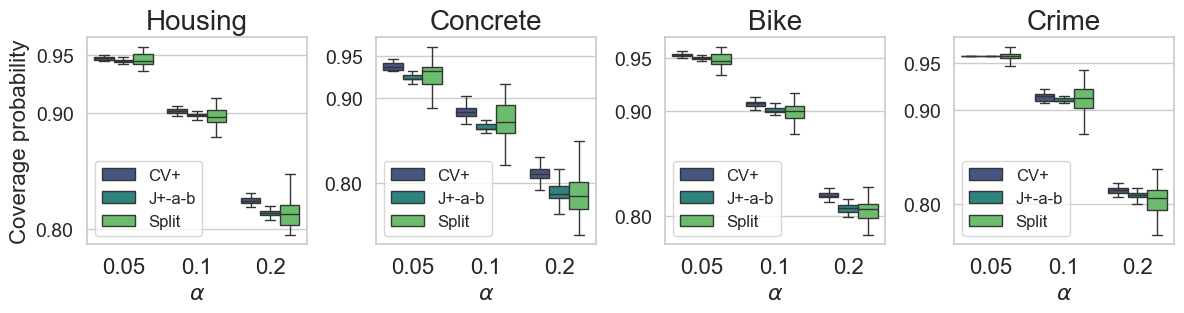

In [6]:
sns.set(style='whitegrid')

hue_order = ["CV+", "J+-a-b", "Split"]
fig, axes = plt.subplots(1, 4, figsize=(12, 3.3))
axes = axes.flatten()

for i in range(4):
    sns.boxplot(
        x='Alpha', y='Cover', hue='Model', data=Cover_dfs[i], 
        palette="viridis", hue_order=hue_order, showfliers=False,
        ax=axes[i]
    )

    axes[i].set_yticks([0.8, 0.9, 0.95], minor=False)
    axes[i].set_xlabel('$\\alpha$', fontsize=16)
    axes[i].xaxis.set_tick_params(labelsize=16)
    axes[i].set_title(data_names[i], fontsize=20)
    axes[i].legend(fontsize=12)
    axes[i].yaxis.set_tick_params(labelsize=14)
    if i == 0:
        axes[i].set_ylabel('Coverage probability', fontsize=16)
    else:
        axes[i].set_ylabel('')

plt.tight_layout()

plt.savefig('RegCover.svg',format='svg',dpi=1200, bbox_inches='tight')

### Average interval length plots

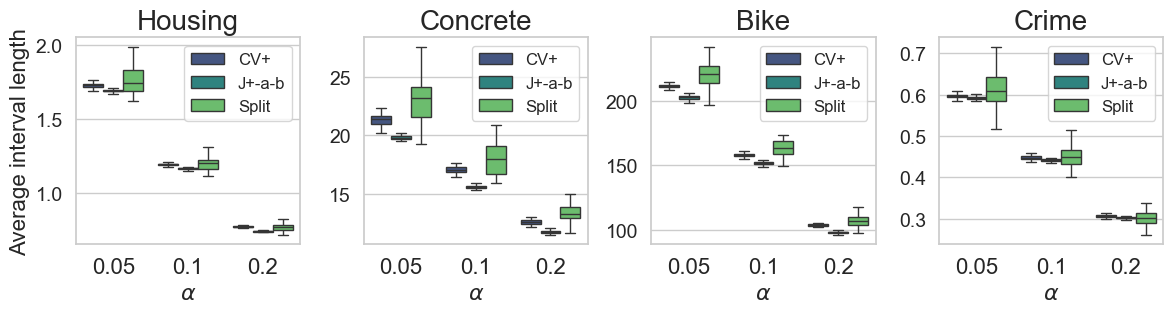

In [8]:
sns.set(style='whitegrid')

hue_order = ["CV+", "J+-a-b", "Split"]
fig, axes = plt.subplots(1, 4, figsize=(12, 3.3))
axes = axes.flatten()

for i in range(4):
    sns.boxplot(
        x='Alpha', y='Size', hue='Model', data=Size_dfs[i], 
        palette="viridis", hue_order=hue_order, showfliers=False,
        ax=axes[i]
    )

    axes[i].set_xlabel('$\\alpha$', fontsize=16)
    axes[i].xaxis.set_tick_params(labelsize=16)
    axes[i].set_title(data_names[i], fontsize=20)
    axes[i].legend(fontsize=12)
    axes[i].yaxis.set_tick_params(labelsize=14)
    if i == 0:
        axes[i].set_ylabel('Average interval length', fontsize=16)
    else:
        axes[i].set_ylabel('')

plt.tight_layout()

plt.savefig('RegSize.svg',format='svg',dpi=1200, bbox_inches='tight')

### Run time plots

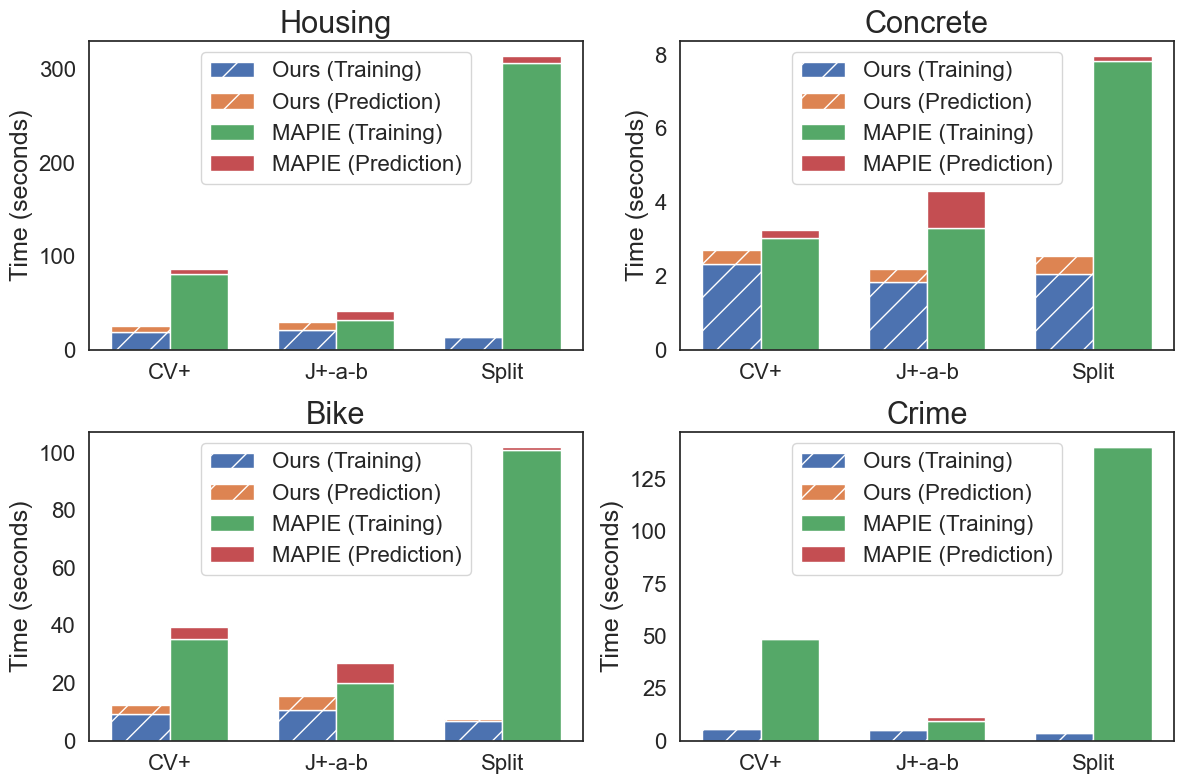

In [32]:
sns.set(style='white')

width = 0.35
packages = ['Ours', 'MAPIE']
patterns = {'Ours' : "/", "MAPIE": ""}
x = np.arange(len(hue_order))

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i in range(4):
    train_means = Time_dfs[i].groupby(['Model', 'Package'])['Train'].mean().unstack(fill_value=0)
    train_means.index[1]
    test_means = Time_dfs[i].groupby(['Model', 'Package'])['Test'].mean().unstack(fill_value=0)
    
    for j, package in enumerate(packages):
        if package in train_means.columns:  
            # Plot training time
            axes[i].bar(x + (j-0.5)*width, 
                    train_means[package],
                    width,
                    label=f'{package} (Training)',
                    hatch=patterns[package])
            
            # Plot testing time (stacked on top)
            axes[i].bar(x + (j-0.5)*width,
                    test_means[package],
                    width,
                    bottom=train_means[package],
                    label=f'{package} (Prediction)',
                    hatch=patterns[package])

            axes[i].legend(fontsize=16, loc="upper center")

    axes[i].set_xticks(x, train_means.index)
    axes[i].xaxis.set_tick_params(labelsize=16)
    axes[i].set_title(data_names[i], fontsize=22)
    axes[i].set_ylabel('Time (seconds)', fontsize=18)
    axes[i].yaxis.set_tick_params(labelsize=16)

plt.tight_layout()

plt.savefig('RegTime.svg',format='svg',dpi=1200, bbox_inches='tight')